In [1]:
from collections import Counter
import random

import matplotlib.pyplot as plt
import torch

# Data

In [2]:
names = open("data/2. First.txt", "r").read().lower().splitlines()
len(names)

1165

In [3]:
# Look at the lengths of the names
lengths = [len(name) for name in names]
min(lengths), max(lengths)

(2, 14)

(array([ 13.,  78., 247., 311., 230., 225.,  42.,  10.,   5.,   4.]),
 array([ 2. ,  3.2,  4.4,  5.6,  6.8,  8. ,  9.2, 10.4, 11.6, 12.8, 14. ]),
 <BarContainer object of 10 artists>)

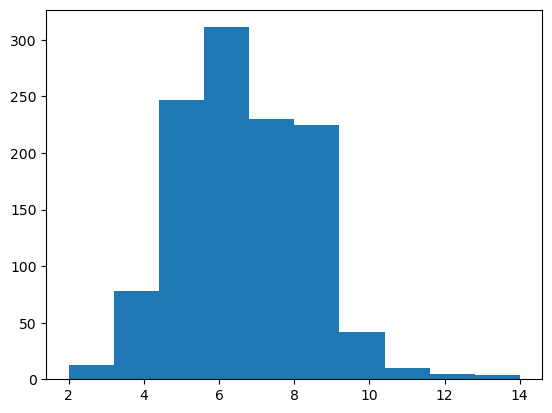

In [4]:
plt.hist(lengths)

In [5]:
# Check if desired start and end tokens are present. Also check if there are spaces in the names.
for name in names:
    if any(token in name for token in ["$", "^", " "]):
        raise ValueError(name)

In [6]:
# Randomly sort names list
random.seed(36)
random.shuffle(names)

In [7]:
split_index = int(0.8 * len(names))
train_names = names[:split_index]
test_names = names[split_index:]

# Bigram model

In [8]:
# Get lookup table for all characters to indexes. ^ = 0 and $ = last index. Also get the reverse lookup table.
chars = list("^abcdefghijklmnopqrstuvwxyz$")
char2int = {ch: i for i, ch in enumerate(chars)}
max_val = max(char2int.values())
# char2int["^"], char2int["$"] = 0, max_val + 1
int2char = {i: ch for ch, i in char2int.items()}

In [9]:
def create_bigram_list(
    names: list[str], start_tok="^", end_tok="$"
) -> list[tuple[str, str]]:
    """Creates a list of bigrams from a list of names. Adds start and end tokens to each name."""
    bigram_list = []
    for name in names:
        # Add start and end tokens
        chs = [start_tok] + list(name) + [end_tok]
        for ch1, ch2 in zip(chs, chs[1:]):
            bigram_list.append((ch1, ch2))
    return bigram_list


def create_bigram_array(
    names: list[str], mapping: dict[str, int] = char2int
) -> tuple[torch.Tensor, torch.Tensor]:
    """Returns a bigram count array (rows = 1st character, columns = 2nd character),
    and its row-normalised version (probabilities, given first character, of each second character).
    Needs a mapping from characters to array indexes."""
    # Initialise array
    bigram_array = torch.zeros((len(mapping), len(mapping)), dtype=torch.int16)
    # Populate array of counts
    for ch1, ch2 in create_bigram_list(names):
        bigram_array[mapping[ch1], mapping[ch2]] += 1
    # Normalise by row sum. Add 1 to avoid 0 probability terms (and infinite loss)
    bigram_probs = (bigram_array + 1) / torch.sum(bigram_array + 1, dim=1, keepdim=True)
    return bigram_array, bigram_probs

In [10]:
bigram_list = create_bigram_list(train_names)
Counter(bigram_list).most_common(10)

[(('s', 'h'), 292),
 (('a', 'n'), 245),
 (('a', '$'), 240),
 (('^', 's'), 208),
 (('h', 'a'), 189),
 (('^', 'a'), 169),
 (('r', 'a'), 149),
 (('i', '$'), 143),
 (('a', 'r'), 135),
 (('h', 'i'), 114)]

In [11]:
# Initialise bigram array
bigram_array, bigram_probs = create_bigram_array(train_names, char2int)

(-0.5, 27.5, 27.5, -0.5)

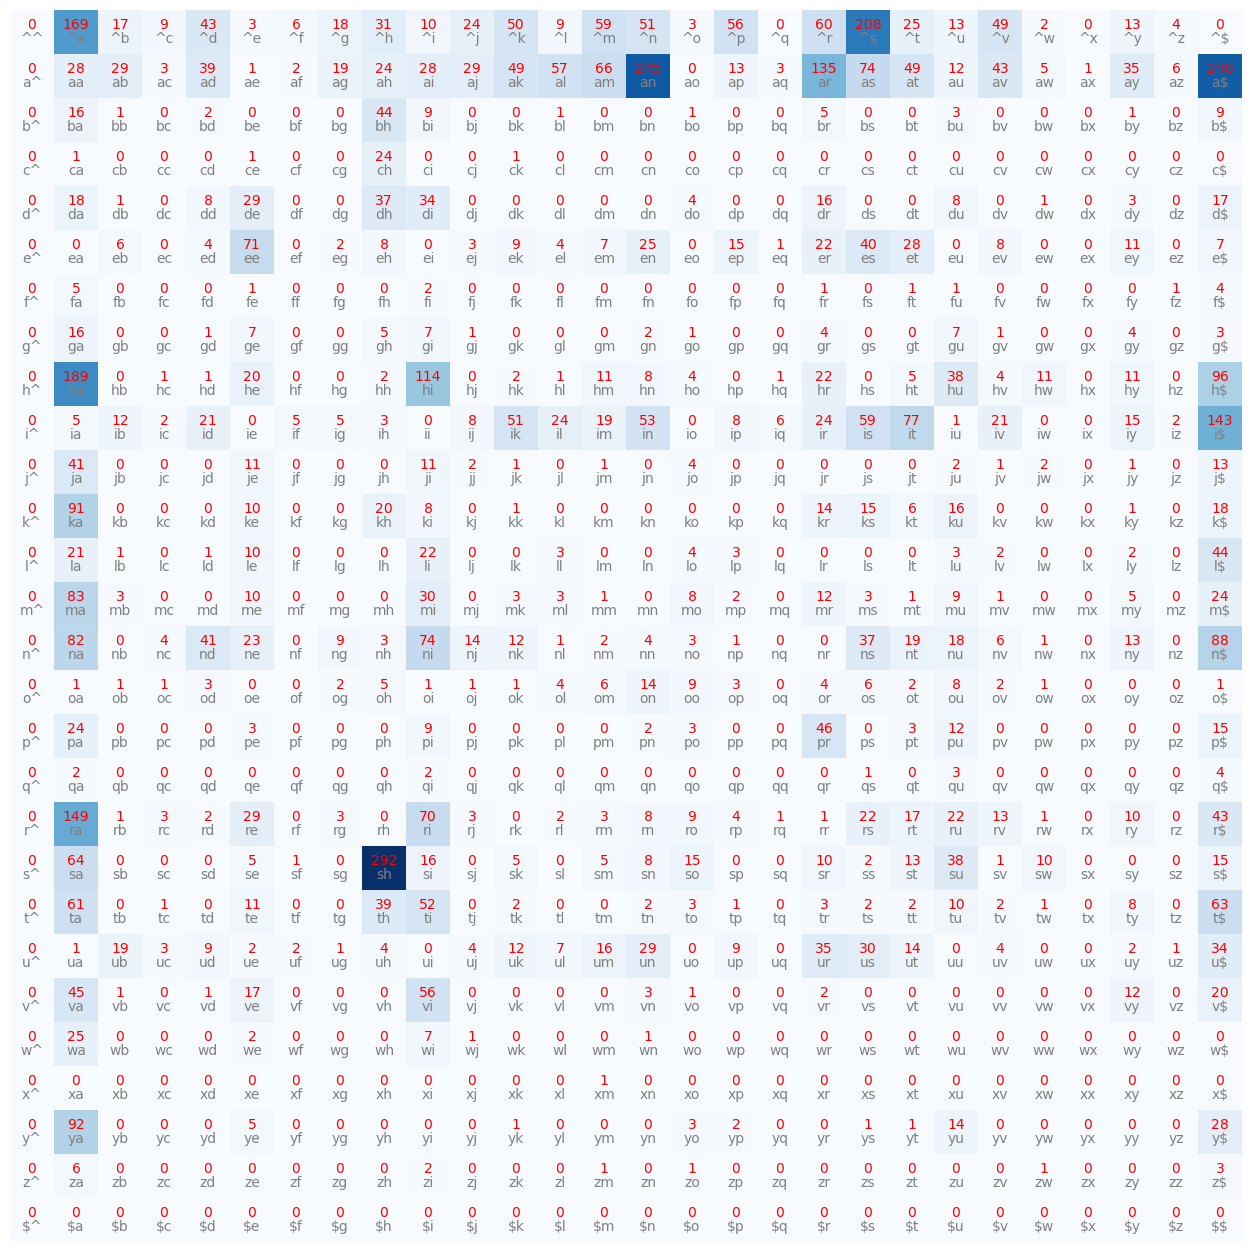

In [12]:
plt.figure(figsize=(16, 16))
plt.imshow(bigram_array, cmap="Blues")
for i in range(len(int2char)):
    for j in range(len(int2char)):
        chars = int2char[i] + int2char[j]
        # Need parsemath=False to avoid error with '$$'
        plt.text(j, i, chars, ha="center", va="top", color="gray", parse_math=False)
        plt.text(j, i, bigram_array[i, j].item(), ha="center", va="bottom", color="red")
plt.axis("off")

In [13]:
# torch.save(bigram_probs, "models/bigram_probs.pt")

# Prediction with bigram model

In [14]:
# bigram_probs = torch.load("models/bigram_probs.pt")

In [15]:
generator = torch.Generator().manual_seed(36)

In [16]:
for i in range(10):
    start_index = torch.multinomial(bigram_probs[0], 1, generator=generator).item()
    start = int2char[start_index]
    while True:
        next_index = torch.multinomial(
            bigram_probs[start_index], 1, generator=generator
        ).item()
        next_char = int2char[next_index]
        if next_char == "^":
            # Resample - this occurs due to smoothing, and is not desired
            continue
        if next_char == "$":
            # End of name
            break
        start += next_char
        start_index = next_index
    print(start)

sn
shit
ldensusha
ishivina
dint
arat
pb
shara
jarandeth
pash


# Calculating losses

In [17]:
# Baseline loss of training data assuming even probabilities
# average negative log-likelihood: lower is better
even_probs = 1 / 27
log_even_probs = torch.log(torch.tensor(even_probs))
-1 * torch.sum(bigram_array * log_even_probs) / (bigram_array.sum())

tensor(3.2958)

In [18]:
# Training loss with bigram model
-1 * torch.nansum(bigram_array * bigram_probs.log()) / (bigram_array.sum())

tensor(2.2638)

In [19]:
# Test loss with bigram model
test_bigram_array, _ = create_bigram_array(test_names, char2int)
-1 * torch.nansum(test_bigram_array * bigram_probs.log()) / (test_bigram_array.sum())

tensor(2.2692)

In [20]:
random_bigram_array, _ = create_bigram_array(["mayank"], char2int)
-1 * torch.nansum(random_bigram_array * bigram_probs.log()) / (
    random_bigram_array.sum()
)

tensor(2.2412)

# Bigram Neural Net

In [107]:
x, y = [], []
bigram_list = create_bigram_list(train_names)
for first, second in bigram_list:
    x.append(char2int[first])
    y.append(char2int[second])
# Convert to tensors
x, y = torch.tensor(x, dtype=torch.int64), torch.tensor(y, dtype=torch.int64)
# One-hot encode
xenc = torch.nn.functional.one_hot(x, num_classes=28).float()

In [112]:
# Single layer, 28 neurons
generator = torch.Generator().manual_seed(36)
n_neurons = 28
layer = torch.randn((28, n_neurons), generator=generator, requires_grad=True)

In [113]:
# Forward pass
def forward(layer, xenc, y, reg=0.0):
    """Forward pass of a single layer."""
    # Neuron activations
    output = xenc @ layer  # (n_samples x 28) @ (28 x n_neurons) = n_samples x n_neurons
    # Softmax for probs
    probs = torch.softmax(output, dim=1)
    # CCE Loss
    # Extract probabilities for correct characters (i.e. each character in y)
    # for each row (each value in the arange), extract the yth value
    prob_correct = probs[torch.arange(len(y)), y]
    # log the probs and take the negative and mean. Add L2 regularisation
    loss = -1 * torch.log(prob_correct).sum() / len(y) + reg * torch.sum(layer**2)
    return loss


loss = forward(layer, xenc, y)
loss

tensor(3.8369, grad_fn=<DivBackward0>)

In [114]:
# Training
loss_history = [loss.item()]

In [115]:
# Backward pass
layer.grad = None
loss.backward()

In [116]:
# Update weights
layer.data -= 0.1 * layer.grad

In [117]:
loss2 = forward(layer, xenc, y)
loss_history.append(loss2.item())

In [126]:
for i in range(1000):
    loss = forward(layer, xenc, y)
    layer.grad = None
    loss.backward()
    layer.data -= 0.1 * layer.grad
    if i % 100 == 0:
        print(f"Loss at iteration {i}: {loss.item():.2f}")
    loss_history.append(loss.item())

Loss at iteration 0: 2.38
Loss at iteration 100: 2.38
Loss at iteration 200: 2.37
Loss at iteration 300: 2.37
Loss at iteration 400: 2.37
Loss at iteration 500: 2.37
Loss at iteration 600: 2.37
Loss at iteration 700: 2.37
Loss at iteration 800: 2.36
Loss at iteration 900: 2.36


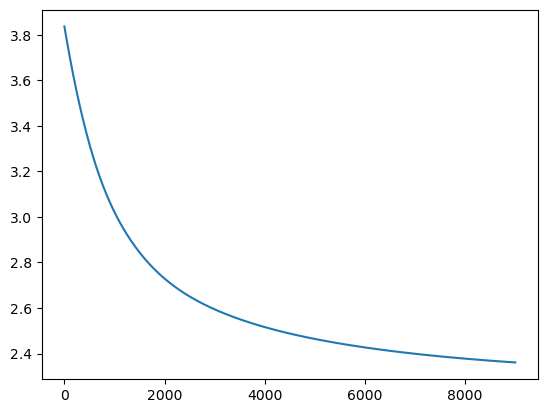

In [127]:
plt.plot(loss_history)

In [129]:
torch.exp(layer)[
    0
]  # analogous to bigram_array[0], but trained by gradient descent instead of counted

tensor([ 0.2138,  8.4388,  0.8021,  0.5385,  2.0631,  0.3442,  0.3227,  0.7369,
         1.3815,  0.5675,  1.1072,  2.4110,  0.2927,  2.8797,  2.4770,  0.3865,
         2.7280,  0.2044,  2.9256, 10.4059,  1.0793,  0.6638,  2.3538,  0.2506,
         0.2036,  0.6265,  0.3615,  0.2198], grad_fn=<SelectBackward0>)

In [146]:
generator = torch.Generator().manual_seed(36)


def predict(xenc, layer=layer, generator=generator):
    """Predicts the next character given a layer and a one-hot encoded character."""
    output = xenc @ layer
    probs = torch.softmax(output, dim=0)
    return torch.multinomial(probs, 1, generator=generator).item()

In [150]:
# Prediction loop
for i in range(10):
    word = "^"
    start = torch.nn.functional.one_hot(
        torch.tensor(char2int[word[-1]]), num_classes=28
    ).float()
    while True:
        torch.no_grad()
        next_index = predict(start)
        next_char = int2char[next_index]
        if next_char == "^":
            continue
        if next_char == "$":
            break
        start = torch.nn.functional.one_hot(
            torch.tensor(next_index), num_classes=28
        ).float()
        word += next_char
    print(word[1:])

dina
arat
pbtit
pr
jarandeth
pesl
kanjappandhalreeshiast
l
aubaraeeen
praman


In [ ]:
# regularised loss